In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import ODESolve as ODE
import ODESolve_slow as ODEslow
import derivatives as der

In [2]:
#initial conditions, thermal distribution od ve, zero vm

In [82]:
N=100
Emax= 10
dm2= 2
th= .5*np.arcsin(.8)
Gf= 10/.29

Eval= np.linspace(Emax/N, Emax, N)

ym0= np.zeros((N,4))
for i in range(len(ym0)):
    p0= 1/(np.exp(Eval[i])+1)
    ym0[i,:]= [p0,0,0,1]


p= np.zeros(N+3)
p[-1]= dm2
p[-2]= th
p[:N]= np.linspace(Emax/N, Emax, N)
p[-3]= Gf

In [83]:
def matrix_maker(y):
    length= len(y)
    matrix = np.zeros((length//4,4))
    
    for i in range(matrix.shape[0]):
        for j in range(4):
            matrix[i,j]= y[4*i+j]
    return matrix


def array_maker(M):
    length= M.shape[0]
    array = np.zeros(length*4)
    
    for i in range(M.shape[0]):
        for j in range(4):
            array[4*i+j] = M[i,j]
            
    return array  

def threeD(y):
    d= matrix_maker(y[0,:])
    matrix= np.zeros((y.shape[0], d.shape[0], 4))
                    
    for i in range(y.shape[0]):
        matrix[i,:,:]= matrix_maker(y[i,:])
    
    return matrix



def dndE(ym0, Eval):
    array= np.zeros(len(ym0))
    for i in range(len(array)):
        p0= ym0[i,0]
        E= Eval[i]
        pz= ym0[i, 3]
        array[i]= .5* p0*(1+pz)*(E**2/2*np.pi**2)
        
    return array


[[ 0.47502081  0.          0.         ...  0.          0.
   1.        ]
 [ 0.47502081 -0.25337619  0.47695344 ... -0.1154169  -0.4568107
   0.88204474]
 [ 0.47502081 -0.11486355 -0.57604255 ... -0.35633197 -0.69449113
   0.62506767]
 ...
 [ 0.47502081 -0.052718   -0.9941031  ... -0.97575377  0.064801
  -0.20905839]
 [ 0.47502081  0.03328271  0.8531627  ... -0.88014841  0.46292905
  -0.10504985]
 [ 0.47502081  0.6160082  -0.70333958 ... -0.6911992   0.71011573
   0.13408697]]


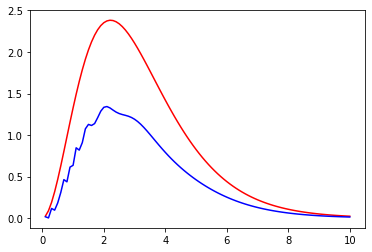

In [95]:
t0= 0
y0= array_maker(ym0)
t0= 0
dt0=  0.01/.8
N_step = 100               
dN = 100
t_final = 50


t, y, dx, end = ODE.ODEOneRun(t0, y0, dt0, p, N_step, dN, t_final)
print(y)

resultsMatrix= threeD(y)
ics= dndE(resultsMatrix[0, :, :], Eval)
later= dndE(resultsMatrix[-1, :, :], Eval)


plt.figure()
plt.plot(Eval, ics, color= 'red')
plt.plot(Eval, later, color= 'blue')

plt.show()

In [96]:
#this is a snapshot in time of where different energy values are in their oscillation. 
#red is initial condition. x axis is energy
#at high energies, after the 10 time steps theres basically no different of probability (oscillation frequency is really small)
#certain energies are lined back up with the inital conditon bc it has already gone through a whole oscilation and probability is back to the initial


In [97]:
#want to find probability that neutrino is initially ve and then later measured as ve..

#integrate over all energies 

In [98]:
def n_ve(ym0, Eval):
    array= dndE(ym0, Eval)
    nve= np.trapz(array, Eval)
    
    return nve

In [99]:
n_ve(resultsMatrix[0,:,:], Eval)
#number density of ve at initial conditon

print(len(t))

43


In [100]:
def probability(ym0, Eval, t, y):
    resultsMatrix= threeD(y)
    array= dndE(ym0, Eval)
    initial= n_ve(resultsMatrix[0,:,:], Eval)
    later= np.zeros(len(t))
    prob_ve= np.zeros(len(t))
    
    for i in range(len(t)):
        later[i]= n_ve(resultsMatrix[i,:,:], Eval)
        prob_ve[i]= later[i]/ initial
    return prob_ve

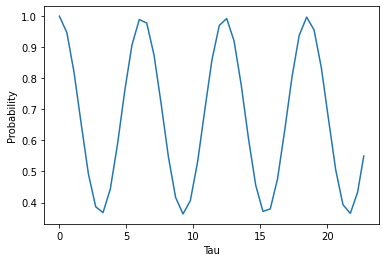

In [101]:
prob_ve= der.probability(ym0, Eval, t, y)
tau= (dm2/(2*2.2))*t

plt.figure()
plt.plot(tau, prob_ve)
plt.xlabel("Tau")
plt.ylabel("Probability")
plt.show()



In [102]:
# 2023-5: incorporating nuetrino nuetrino interactions 
#ym0 is the initial conditions matrix for each energy (Nx4)
#y is an array of arrays...matrix maker turns it into a matrix



In [103]:
def v_function(ym, Eval, Gf):
    v= np.zeros(3)
    yx= Eval[:]**2*ym[:,0]*ym[:,1]
    yy= Eval[:]**2*ym[:,0]*ym[:,2]
    yz= Eval[:]**2*ym[:,0]*ym[:,3]
    x_integral= np.trapz(yx , Eval)
    y_integral= np.trapz(yy , Eval)
    z_integral= np.trapz(yz , Eval)
    v[0]= ((np.sqrt(2)*Gf)/(2*np.pi**2))*x_integral
    v[1]= ((np.sqrt(2)*Gf)/(2*np.pi**2))*y_integral
    v[2]= ((np.sqrt(2)*Gf)/(2*np.pi**2))*z_integral
    return v

In [104]:
ym= matrix_maker(y[0,:])
v_function(ym, Eval, 1)

array([0.       , 0.       , 0.1287678])

In [105]:
Gf=1
test= np.sqrt(2)*Gf*(3/(4*np.pi**2))*1.20206
print(test)

0.12918219558515703


In [106]:
print(ym[i,:])

[4.53978687e-05 0.00000000e+00 0.00000000e+00 1.00000000e+00]


In [107]:
def vv(ym, v):
    der= np.zeros(4)
    der[0]= 0
    der[1]= v[1]*ym[3]- v[2]*ym[2]
    der[2]= v[2]*ym[1]- v[0]*ym[3]
    der[3]= v[0]*ym[2]- v[1]*ym[1]
    
    return der